## Projection of LiDAR point cloud onto an image - KITTI dataset

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy

In [2]:
import sys
sys.path.append('../')
from lidar_convenience import LidarTools

In [3]:
def read_kitti_calib(file_path):
    float_chars = set("0123456789.e+- ")
    calib_data = {}
    with open(file_path, 'r') as f:
        for line in f.readlines():
            key, value = line.split(':', 1)
            value = value.strip()
            calib_data[key] = value
            if float_chars.issuperset(value):
                    # each value is stored in float64
                    calib_data[key] = np.array(list(map(float, value.split(' '))))
    return calib_data

In [4]:
def get_projection_mappings_selector(pixel_mappings, img):
    x, y = pixel_mappings
    h, w = img.shape[0], img.shape[1]
    return (y < h) * (y > 0) * (x < w) * (x > 0)

In [5]:
def get_projection_mappings(points, calib_data, img=None, return_selector=False):
    transformation = calib_data['Tr_velo_to_cam'].reshape(3, 4)
    rectification = calib_data['R0_rect'].reshape(3, 3)
    projection = calib_data['P2'].reshape(3, 4)

    _points = copy.deepcopy(points.T)

    # Convert filtered velodyne coordinates(X_v, Y_v, Z_v) to camera coordinates(X_c, Y_c, Z_c) 
    for i in range(_points.shape[1]):
        _points[:3,i] = np.matmul(transformation, _points[:,i]) # only x, y, z are changed.

    # Rectification
    _points = np.delete(_points, 3, axis=0) # we don't need r amymore
    for i in range(_points.shape[1]):
        _points[:,i] = np.matmul(rectification, _points[:,i])

    # Convert camera coordinates(X_c, Y_c, Z_c) image(pixel) coordinates(x,y)
    projection = projection[:3, :3]
    for i in range(_points.shape[1]):
        _points[:,i] = np.matmul(projection, _points[:,i]) 
    # Normalize
    _points = _points[::]/_points[::][2]
    _points = np.delete(_points, 2, axis=0)
    _points = np.floor(_points).astype(int)
    
    x, y = _points
    if img is None:
        return x, y
    selector = get_projection_mappings_selector(pixel_mappings=_points, img=img)
    if return_selector:
        return x[selector], y[selector], selector
    return x[selector], y[selector]

### Example

In [6]:
def mark_pixels(x, y):
    hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    for i in range(x.shape[0]):
        cv2.circle(hsv_img, (x[i], y[i]), 1, (85,255,255), -1)
    return cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)

In [7]:
def project_points(points, img, calib_data):
    x, y = get_projection_mappings(points, calib_data, img)
    return mark_pixels(x, y)

In [8]:
points_path = 'sample_data/umm_000015.bin'
img_path = 'sample_data/umm_000015.png'
calib_path = 'sample_data/umm_000015.txt'

In [9]:
points = np.fromfile(points_path, dtype=np.float32).reshape(-1, 4)
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
calib_data = read_kitti_calib(calib_path)

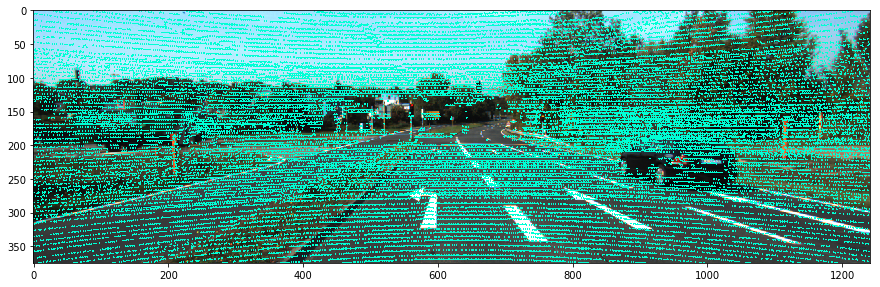

In [10]:
projected_img = project_points(points, img, calib_data)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
plt.imshow(projected_img)

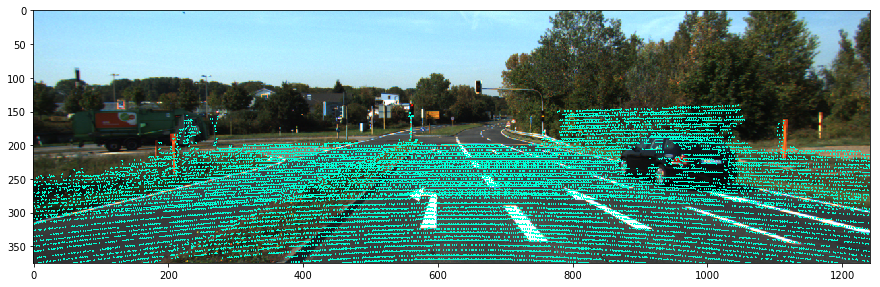

In [11]:
filtered_points = LidarTools().filter_points(points, side_range=(-20, 20), fwd_range=(6, 46))
projected_img = project_points(filtered_points, img, calib_data)
f, axes = plt.subplots(1, 1, figsize=(15, 15))
plt.imshow(projected_img)